## Part 0: Loading Dataset and Dependencies.

In [1]:
pip install ucimlrepo

In [2]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e2fa36bd21e8fe5bafcfc23263a09e4c9597548c377828ce26515e7ce8cbcbb0
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
import lime
import lime.lime_tabular


In [4]:
phiusiil_phishing_url_website = fetch_ucirepo(id=967)

In [5]:
X = phiusiil_phishing_url_website.data.features
y = phiusiil_phishing_url_website.data.targets

In [6]:
print(phiusiil_phishing_url_website.metadata)
print(phiusiil_phishing_url_website.variables)

{'uci_id': 967, 'name': 'PhiUSIIL Phishing URL (Website)', 'repository_url': 'https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/967/data.csv', 'abstract': 'PhiUSIIL Phishing URL Dataset is a substantial dataset comprising 134,850 legitimate and 100,945 phishing URLs. Most of the URLs we analyzed, while constructing the dataset, are the latest URLs. Features are extracted from the source code of the webpage and URL. Features such as CharContinuationRate, URLTitleMatchScore, URLCharProb, and TLDLegitimateProb are derived from existing features.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 235795, 'num_features': 54, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['label'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2024, 'last_updated': 'Sun May 12 

In [7]:
df = pd.concat([X, y], axis=1)

## PART 1: Dataset Preprocessing

### 1.1 Clean Columns and Remove Duplicates

In [8]:
# Drop only the columns that exist
columns_to_drop = ['FILENAME', 'URL', 'Domain', 'Title']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

df_cleaned = df.drop(columns=existing_columns_to_drop)

# Remove duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

print(f"Dataset shape after removing duplicates: {df_cleaned.shape}")



Dataset shape after removing duplicates: (234987, 52)


### 1.2 Handle Missing Values (Mean Imputation)

In [9]:
# Fill missing values with column mean for numerical data
df_cleaned.fillna(df_cleaned.mean(numeric_only=True), inplace=True)

### 1.3 Categorical Encoding

In [10]:
# Encoding 'TLD' and 'Robots'
label_enc = LabelEncoder()
df_cleaned['TLD'] = label_enc.fit_transform(df_cleaned['TLD'])
df_cleaned['Robots'] = label_enc.fit_transform(df_cleaned['Robots'])


### 1.4 Feature Scaling

In [11]:
# Separate features and target
X = df_cleaned.drop(columns=['label'])
y = df_cleaned['label']

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 1.5 Apply SMOTE

In [12]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print(f"After SMOTE, class distribution:\n{pd.Series(y_resampled).value_counts()}")

After SMOTE, class distribution:
label
1    134850
0    134850
Name: count, dtype: int64


## Part 2: Train-Test Split with Stratification

In [13]:
# Perform stratified train-test split on the SMOTE-resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,
    random_state=42
)

# Check results
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train label distribution:\n", y_train.value_counts())
print("Test label distribution:\n", y_test.value_counts())


Train shape: (215760, 51)
Test shape: (53940, 51)
Train label distribution:
 label
0    107880
1    107880
Name: count, dtype: int64
Test label distribution:
 label
0    26970
1    26970
Name: count, dtype: int64


## Part 3: Feature Selection (SelectKBest with ANOVA F-test)

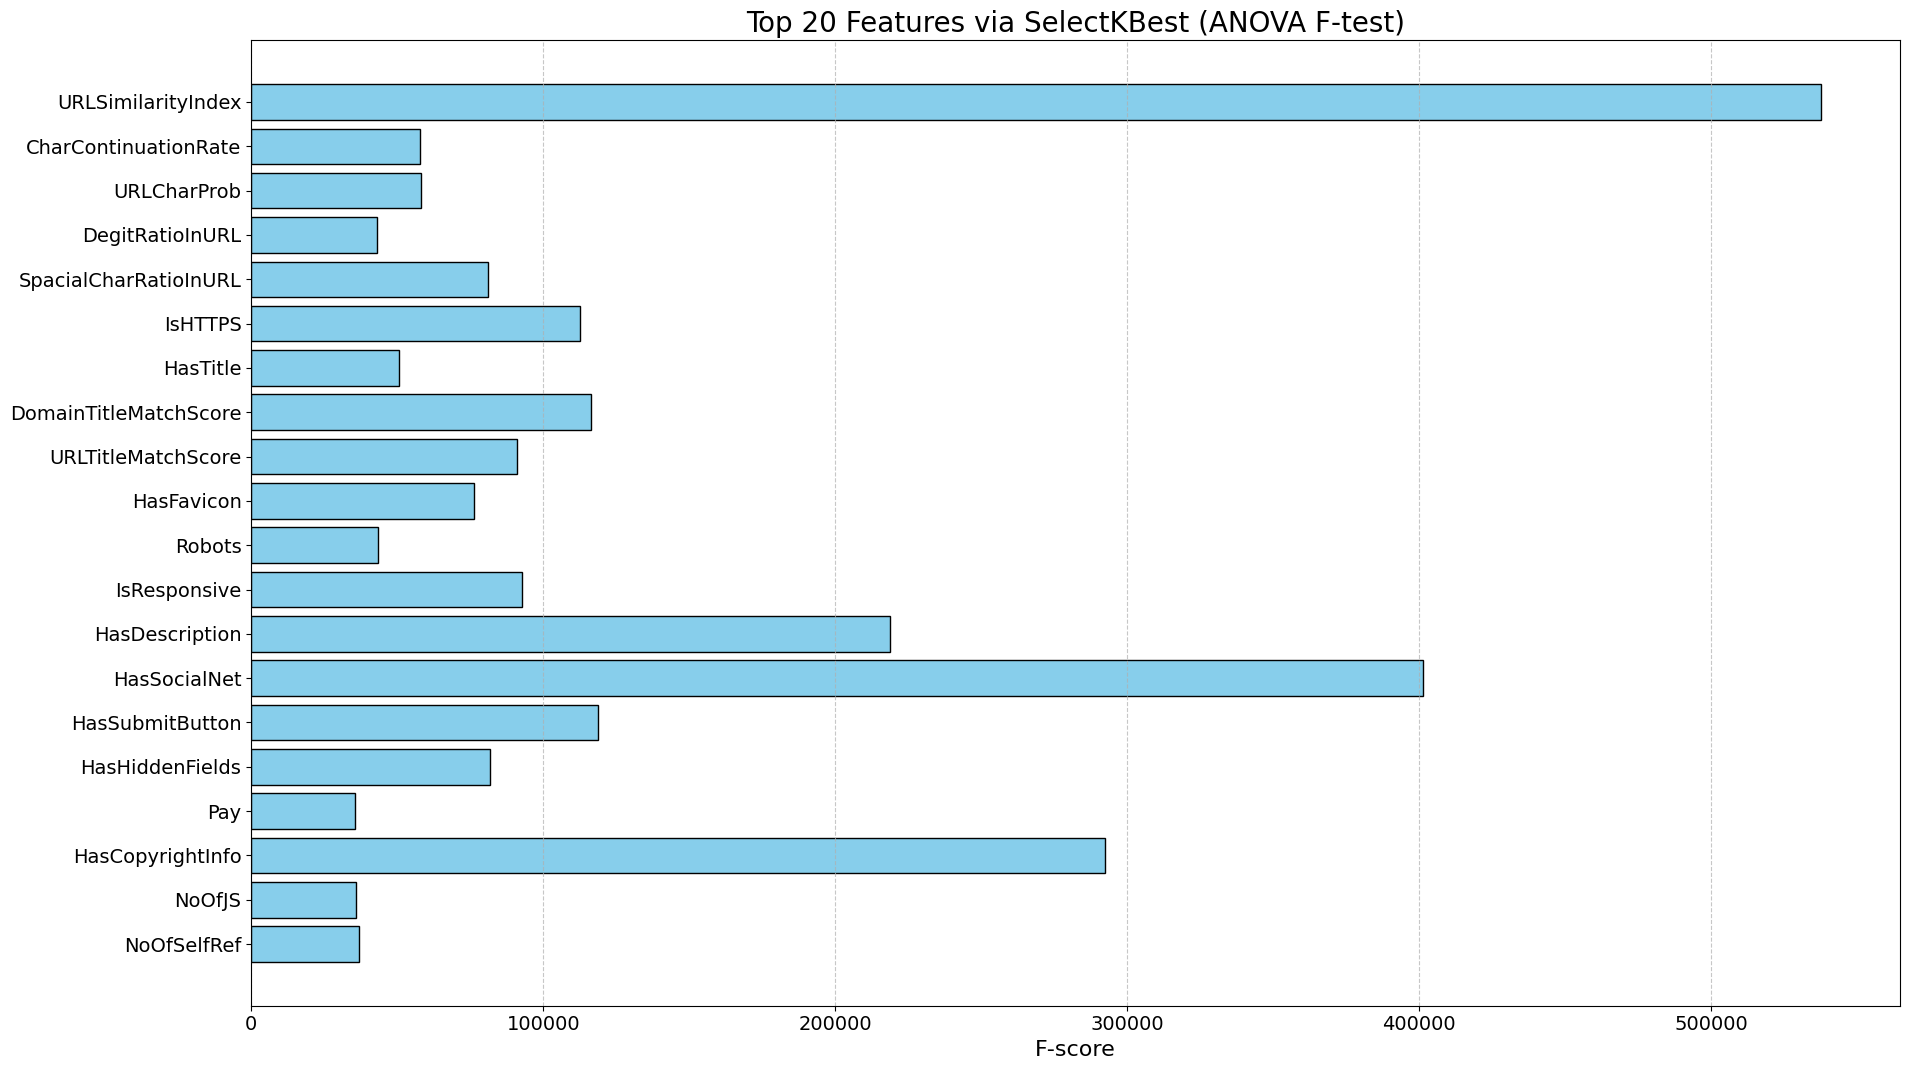

In [20]:
# Apply SelectKBest to training data
selector = SelectKBest(score_func=f_classif, k=20)
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs = selector.transform(X_test)

# Get indices and scores of selected features
selected_indices = selector.get_support(indices=True)
scores = selector.scores_

# Get the original feature names
feature_names = X.columns
selected_feature_names = [feature_names[i] for i in selected_indices]

# Plot scores
# --------------------------------------------------
# Create figure 1920x1080 pixels at 100 DPI
plt.figure(figsize=(19.2, 10.8))

# Plot F-scores
plt.barh(selected_feature_names, [scores[i] for i in selected_indices], color='skyblue', edgecolor='black')

# Axis labels and title
plt.xlabel("F-score", fontsize=16)
plt.title("Top 20 Features via SelectKBest (ANOVA F-test)", fontsize=20)
plt.gca().invert_yaxis()

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust tick label sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

## Part 4: Model training, hyperparameter optimization, and stackin

### 4.1 Decision Tree Classifier with GridSearchCV

In [22]:
# Initialize models dictionary
models = {}

In [23]:
# Decision Tree
dt_params = {'max_depth': [5, 10, 20], 'criterion': ['gini', 'entropy']}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=3, scoring='f1', n_jobs=-1)
dt.fit(X_train_fs, y_train)
models['Decision Tree'] = dt.best_estimator_


### 4.2 Support Vector Machine (SVM) with GridSearchCV

In [24]:
# SVM
svm_params = {'C': [0.1, 1], 'kernel': ['linear', 'rbf']}
svm = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=3, scoring='f1', n_jobs=-1)
svm.fit(X_train_fs, y_train)
models['SVM'] = svm.best_estimator_


### 4.3 Random Forest Classifier with GridSearchCV

In [25]:
# Random Forest
rf_params = {'n_estimators': [100], 'max_depth': [10, 20]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1', n_jobs=-1)
rf.fit(X_train_fs, y_train)
models['Random Forest'] = rf.best_estimator_


### 4.4 Logistic Regression with GridSearchCV



In [26]:
# Logistic Regression
lr_params = {'C': [0.1, 1, 10]}
lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=3, scoring='f1', n_jobs=-1)
lr.fit(X_train_fs, y_train)
models['Logistic Regression'] = lr.best_estimator_


### 4.5 Stacking Classifier with Logistic Regression as Meta Learner

In [27]:
# Stacking Classifier
stack = StackingClassifier(
    estimators=[
        ('dt', models['Decision Tree']),
        ('svm', models['SVM']),
        ('rf', models['Random Forest'])
    ],
    final_estimator=LogisticRegression(),
    cv=3
)
stack.fit(X_train_fs, y_train)
models['Stacking'] = stack

### 4.6 Gradient Boosting Classifier with GridSearchCV

In [28]:
# Gradient Boosting
gb_params = {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3, 5]}
gb = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='f1', n_jobs=-1)
gb.fit(X_train_fs, y_train)
models['Gradient Boosting'] = gb.best_estimator_


### 4.7 K-Nearest Neighbors (KNN) with GridSearchCV

In [29]:
# Define KNN parameter grid
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

# Setup GridSearchCV
knn = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

knn.fit(X_train_fs, y_train)
models['KNN'] = knn.best_estimator_


### 4.8 XGBoost Classifier (Extreme Gradient Boosting) with GridSearchCV

In [30]:
# XGBoost with GridSearchCV
xgb_params = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3, 5]
}

xgb = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    xgb_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

xgb.fit(X_train_fs, y_train)
models['XGBoost'] = xgb.best_estimator_


### Trained Models

In [31]:
# Output trained models' names
list(models.keys())

['Decision Tree',
 'SVM',
 'Random Forest',
 'Logistic Regression',
 'Stacking',
 'Gradient Boosting',
 'KNN',
 'XGBoost']

## Part 5: Model Evaluation – Classification Metrics


🔍 Model: Decision Tree
✅ Training Accuracy: 0.9999
✅ Test Accuracy: 0.9999

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26970
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940

📈 AUC-ROC Score: 1.0000


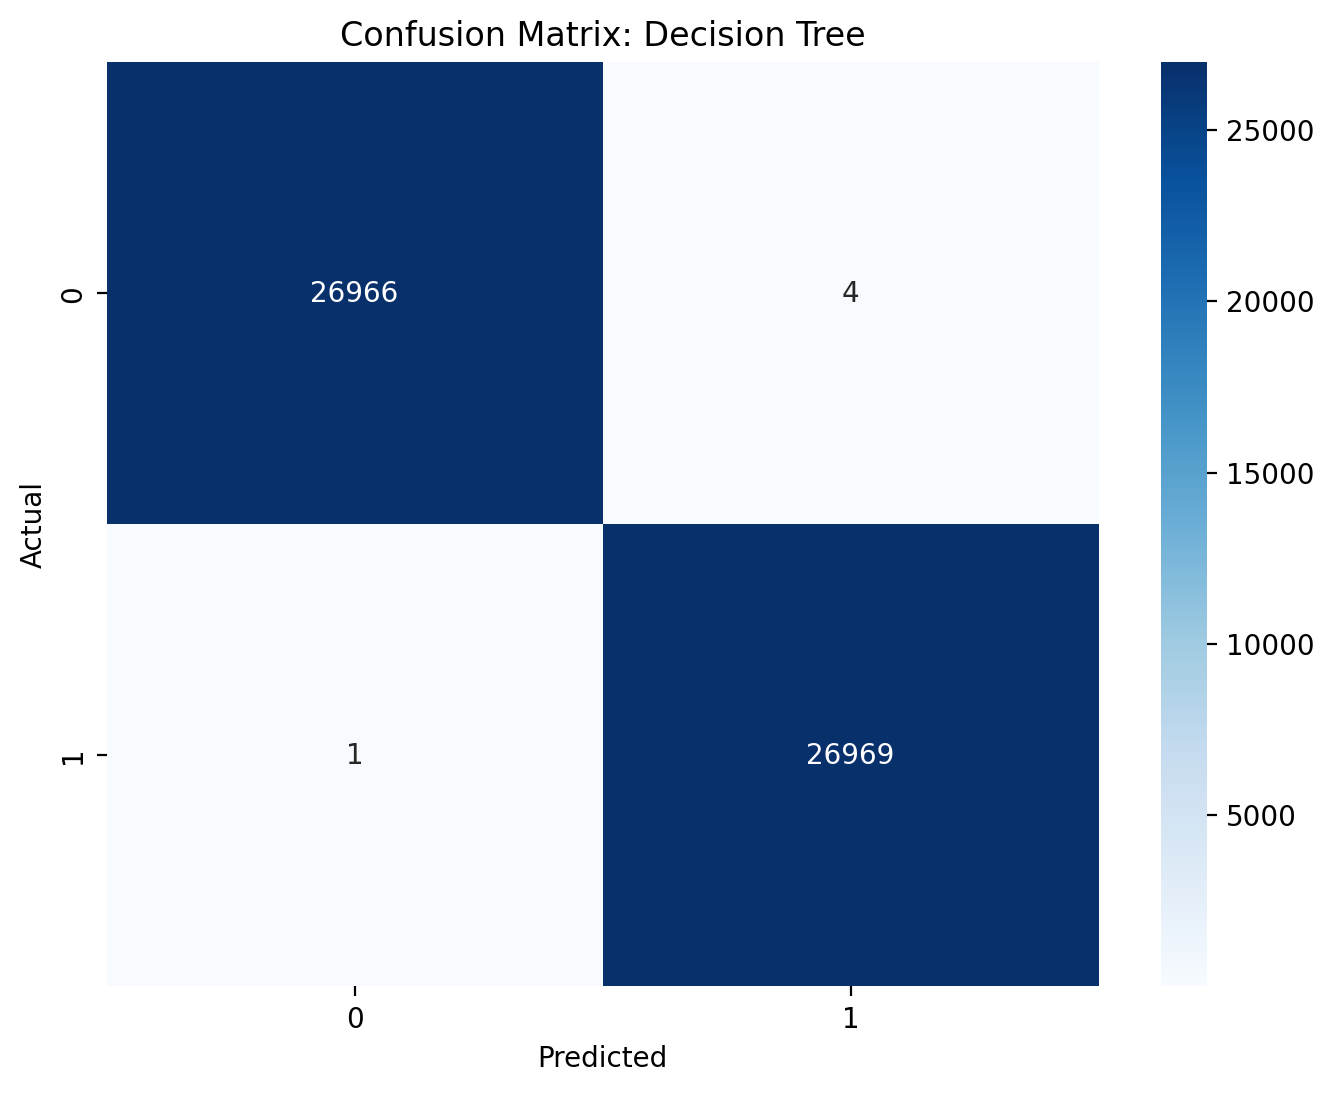

 

🔍 Model: SVM
✅ Training Accuracy: 0.9999
✅ Test Accuracy: 0.9999

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26970
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940

📈 AUC-ROC Score: 1.0000


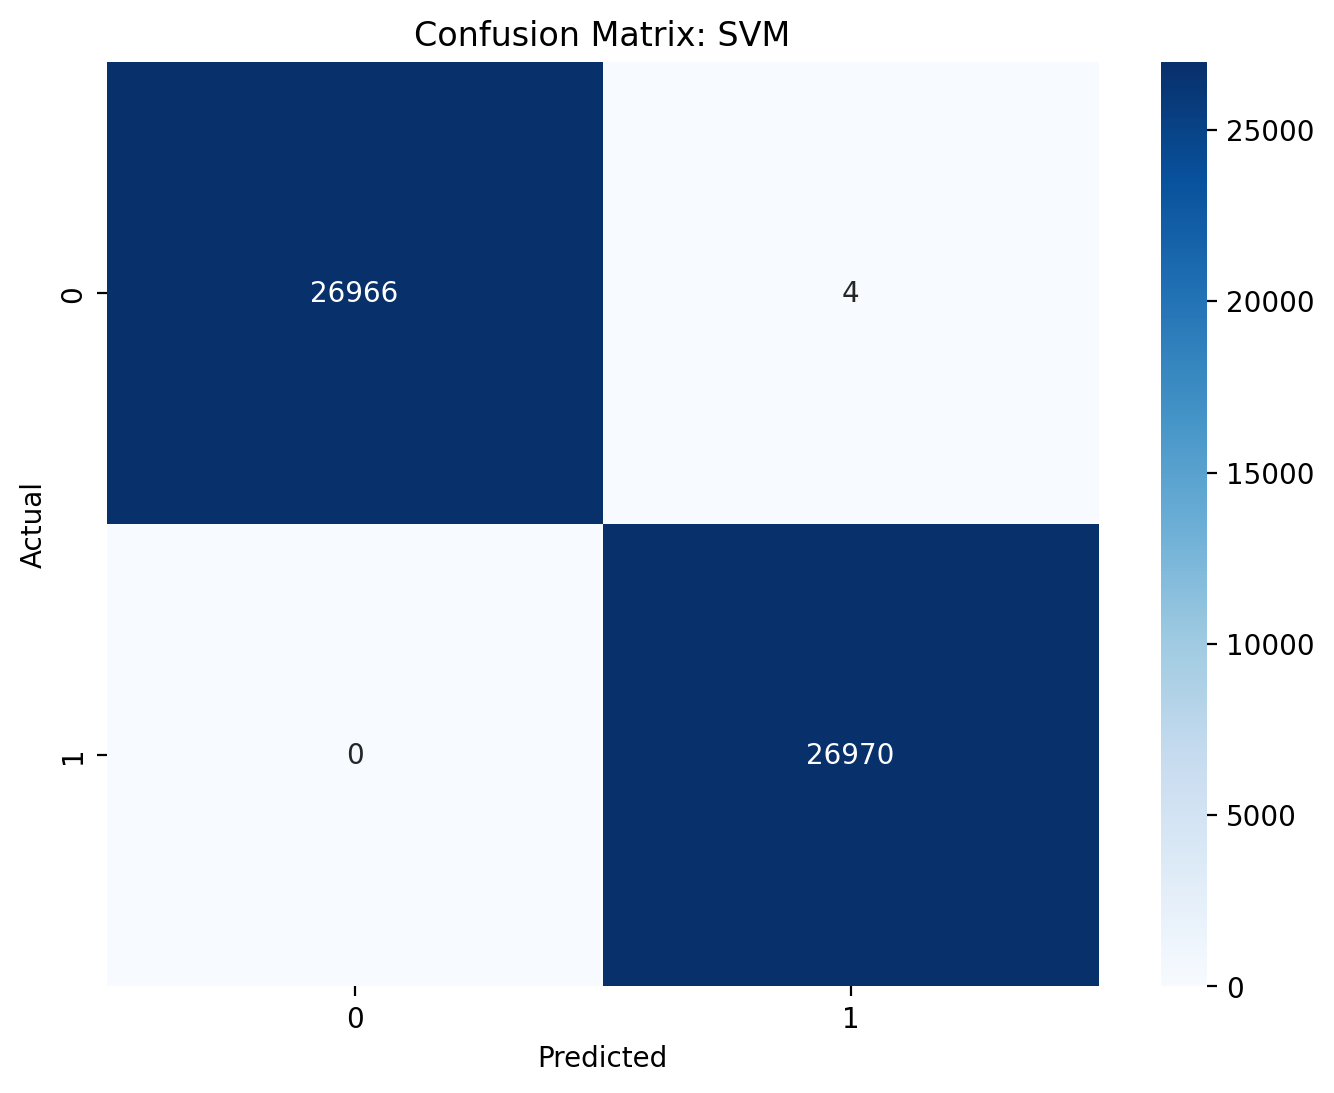

 

🔍 Model: Random Forest
✅ Training Accuracy: 1.0000
✅ Test Accuracy: 1.0000

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26970
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940

📈 AUC-ROC Score: 1.0000


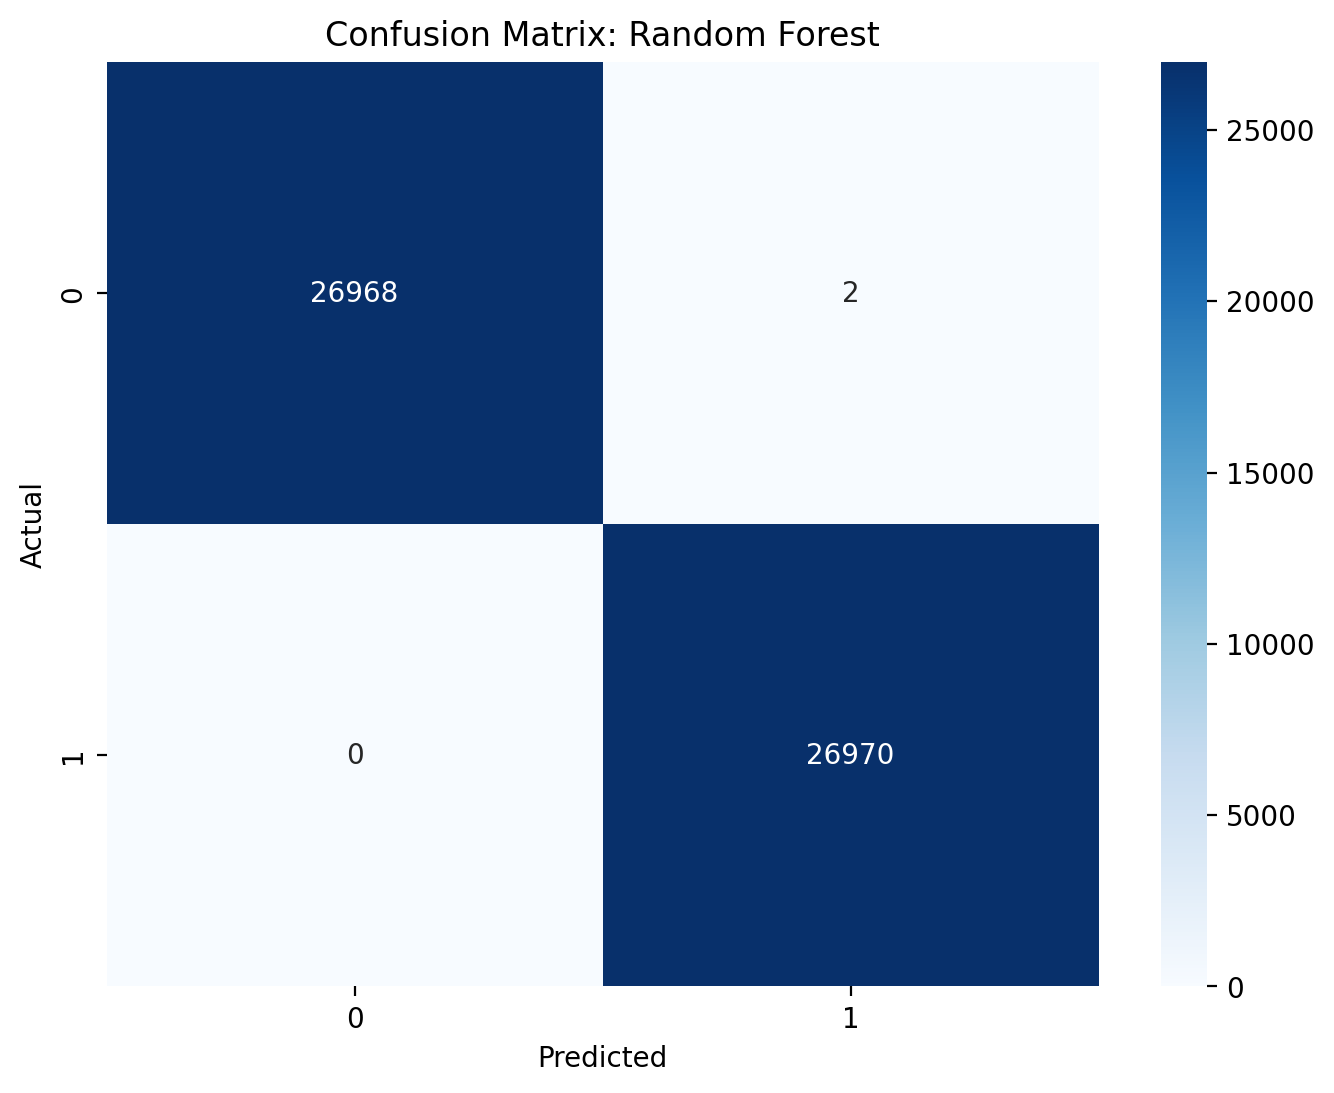

 

🔍 Model: Logistic Regression
✅ Training Accuracy: 0.9999
✅ Test Accuracy: 0.9999

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26970
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940

📈 AUC-ROC Score: 1.0000


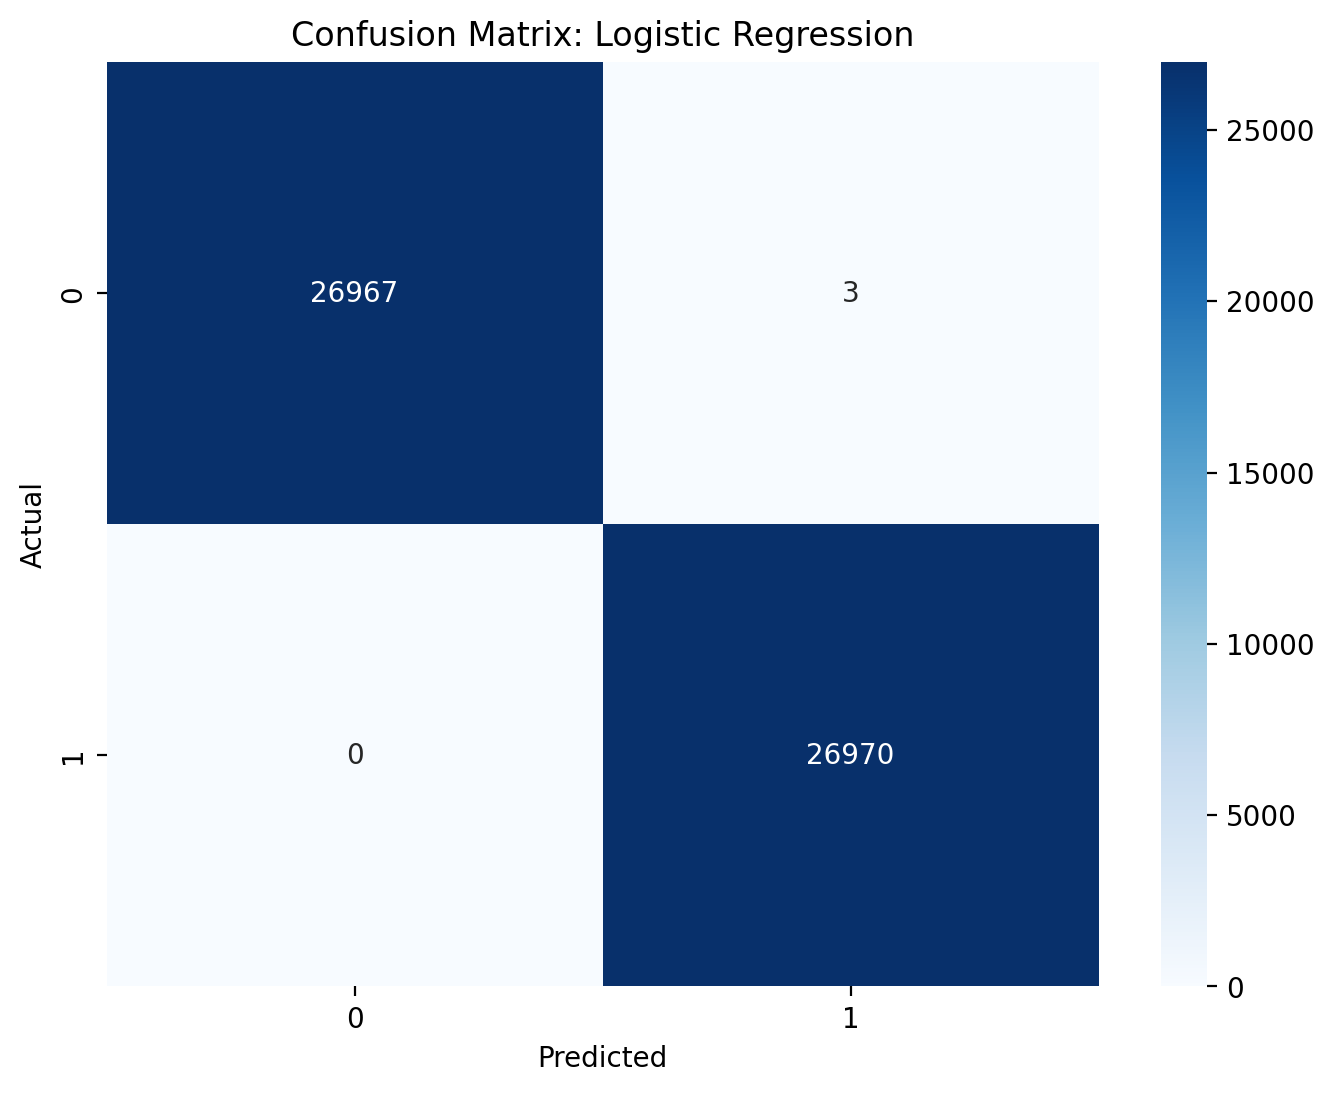

 

🔍 Model: Stacking
✅ Training Accuracy: 0.9999
✅ Test Accuracy: 0.9999

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26970
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940

📈 AUC-ROC Score: 1.0000


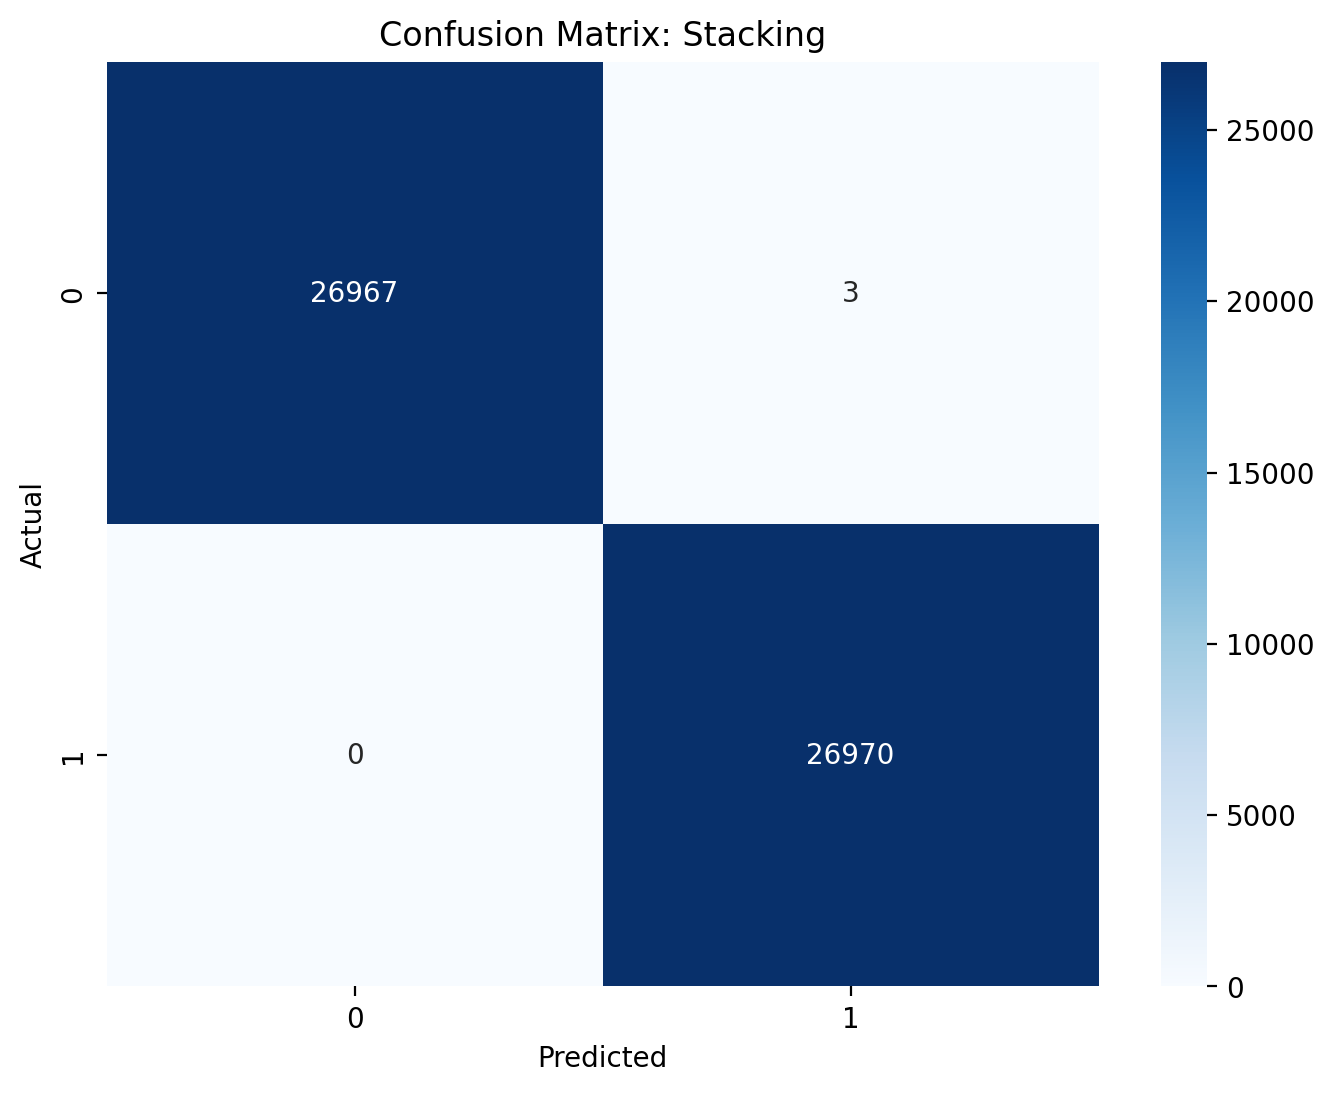

 

🔍 Model: Gradient Boosting
✅ Training Accuracy: 0.9999
✅ Test Accuracy: 0.9999

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26970
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940

📈 AUC-ROC Score: 1.0000


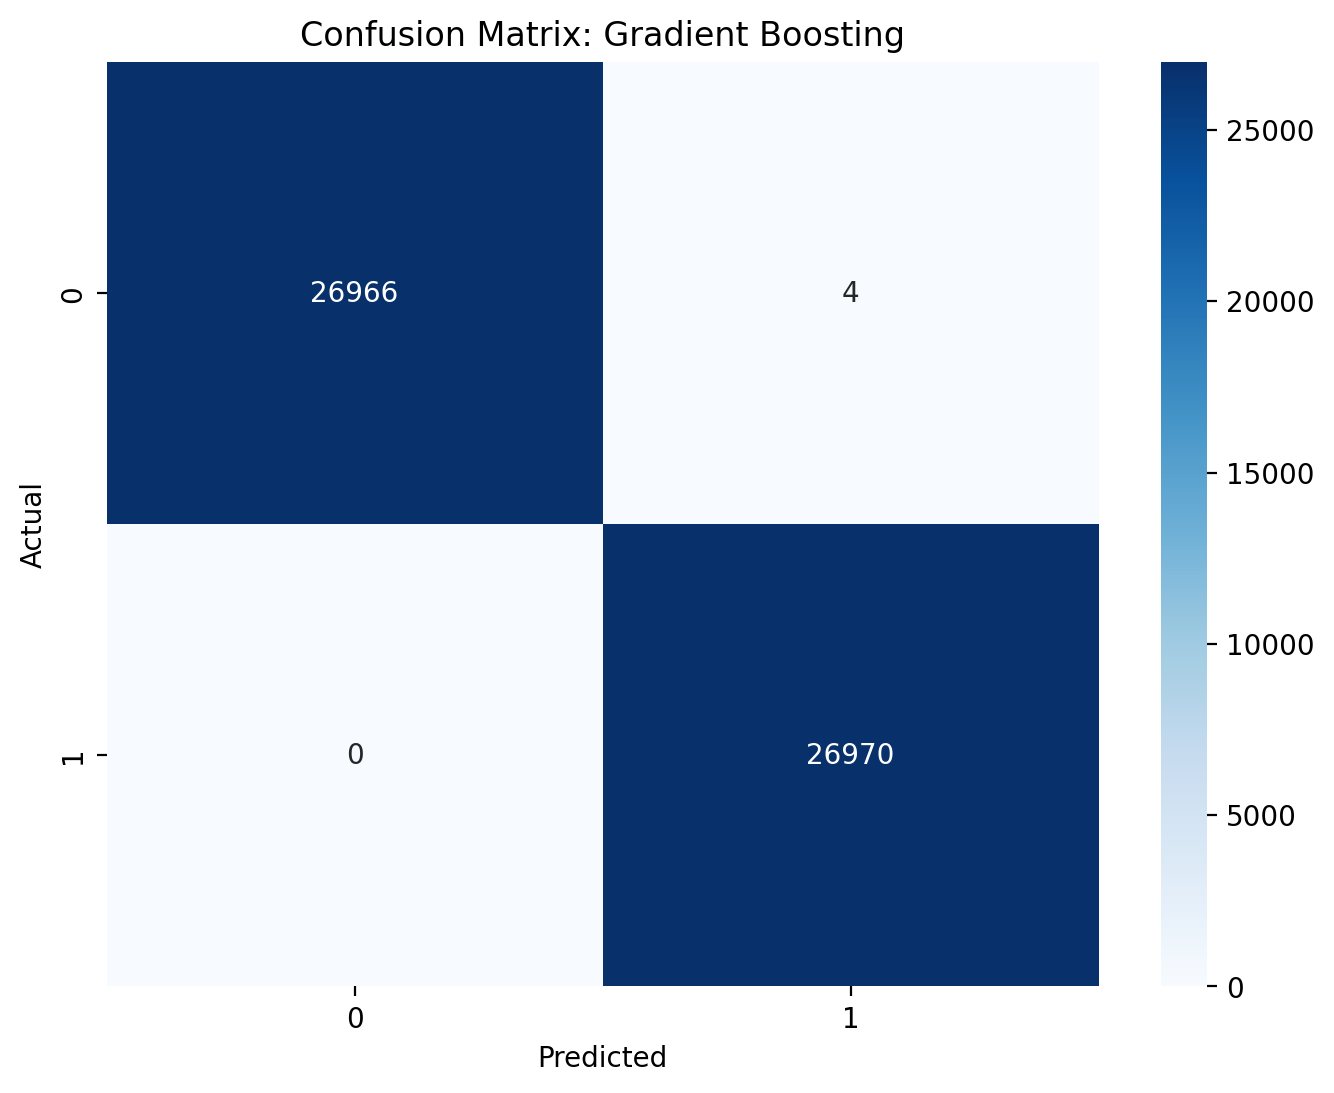

 

🔍 Model: KNN
✅ Training Accuracy: 1.0000
✅ Test Accuracy: 0.9990

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26970
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940

📈 AUC-ROC Score: 0.9994


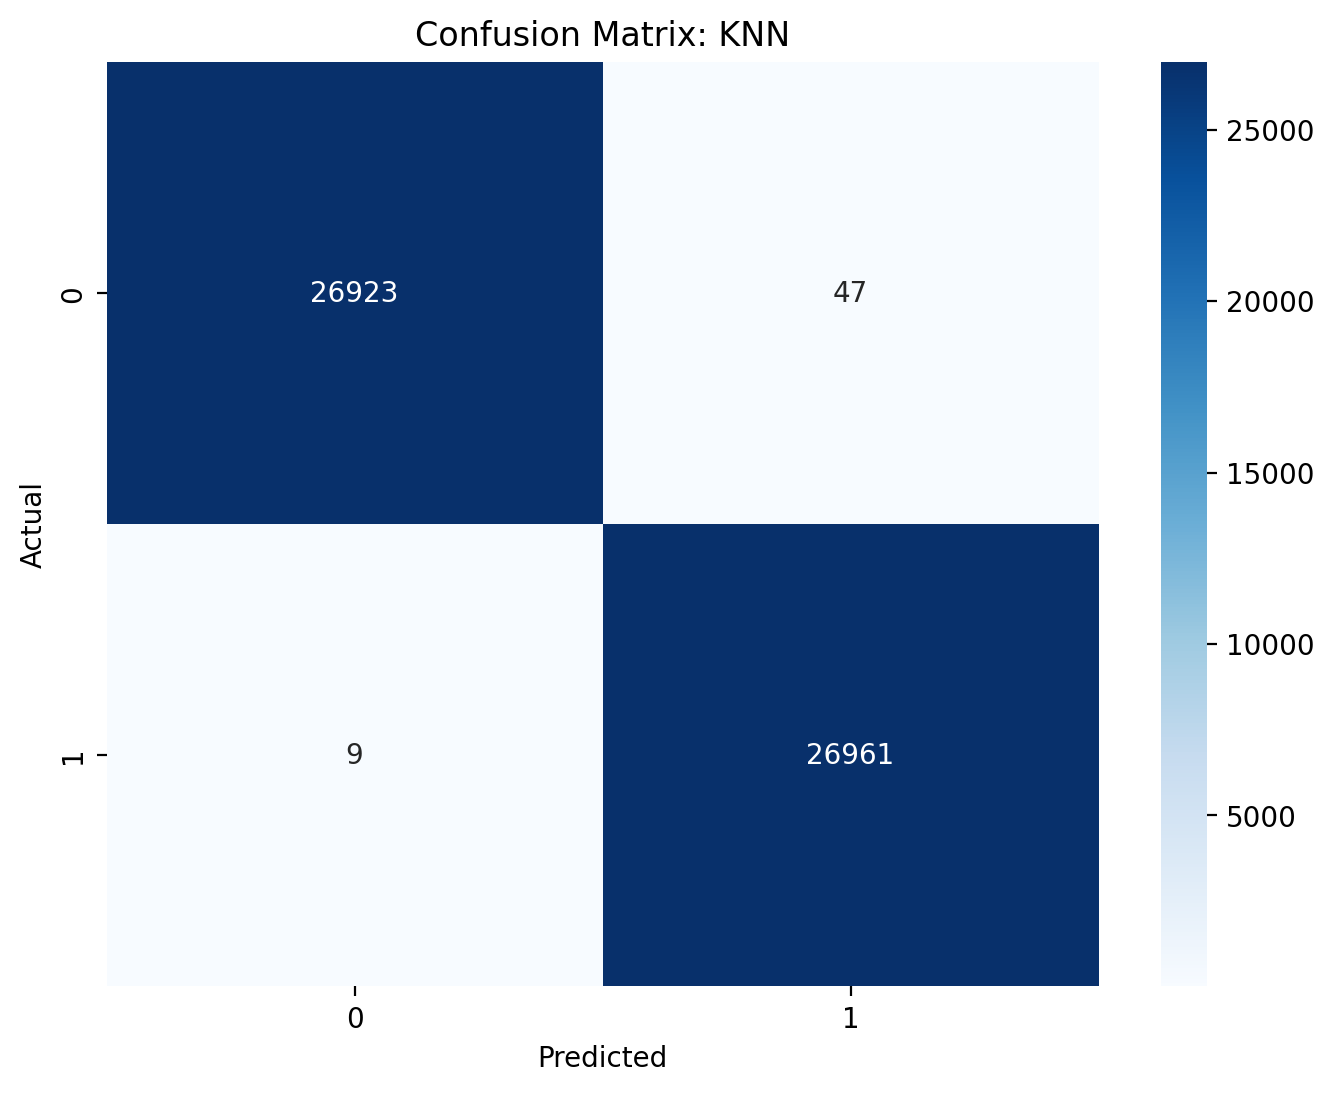

 

🔍 Model: XGBoost
✅ Training Accuracy: 1.0000
✅ Test Accuracy: 0.9999

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26970
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940

📈 AUC-ROC Score: 1.0000


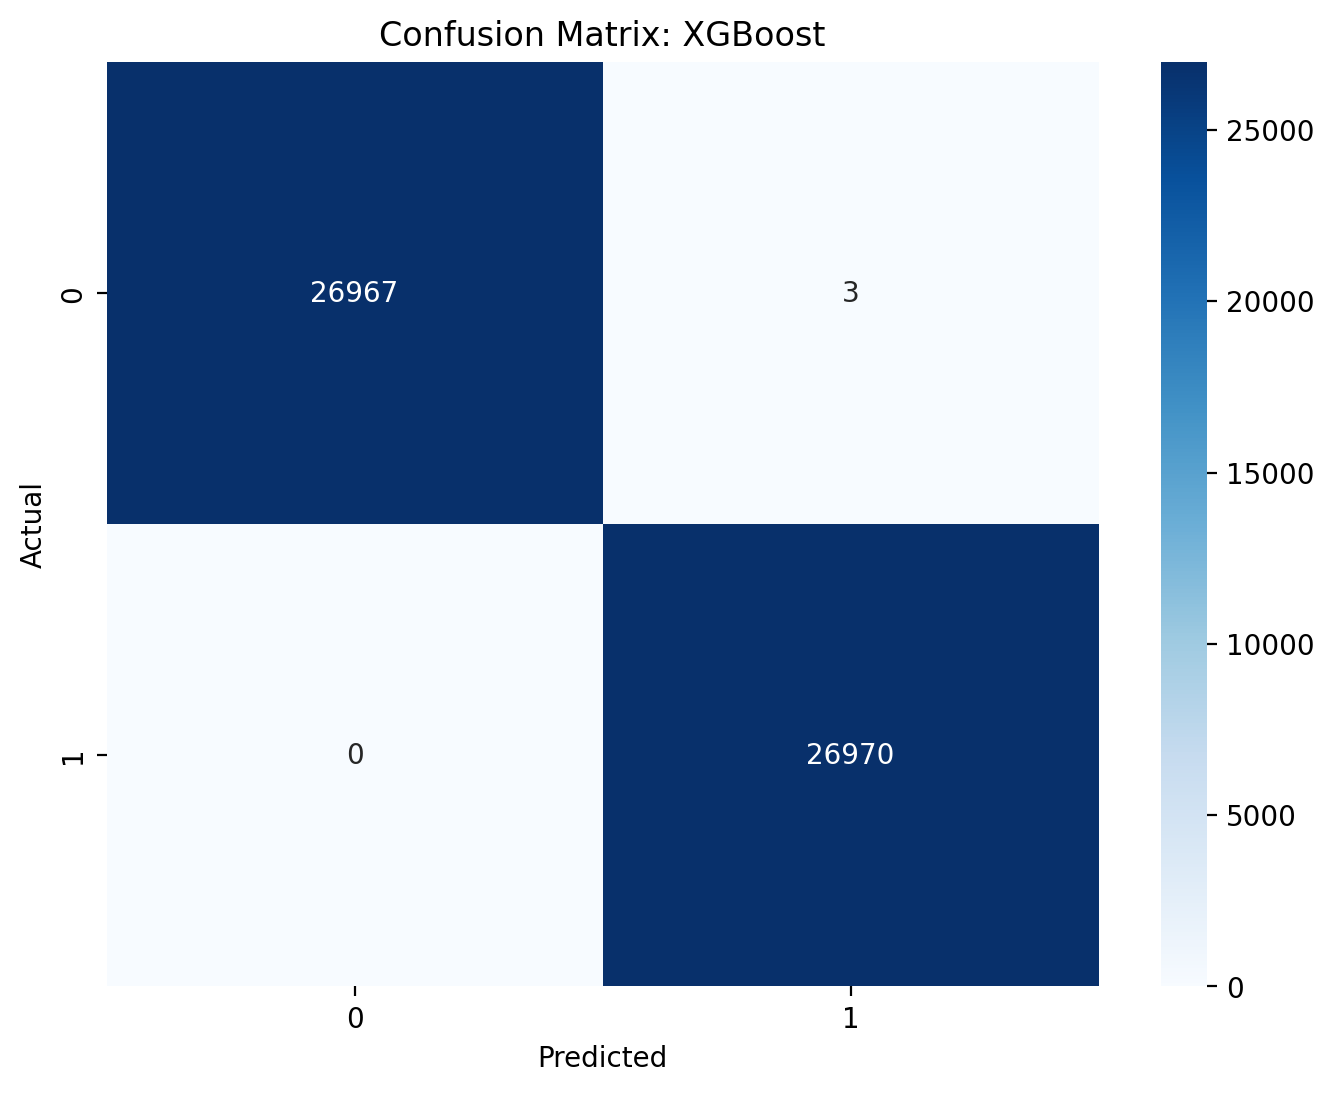

In [37]:
# Evaluate each model
for name, model in models.items():
    print(f"\n🔍 Model: {name}")

    # Predictions
    y_train_pred = model.predict(X_train_fs)
    y_test_pred = model.predict(X_test_fs)

    # Probabilities (for AUC)
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test_fs)[:, 1]
    else:
        # For SVM without probability=True, fallback to decision function
        y_test_proba = model.decision_function(X_test_fs)

    # Accuracy
    print(f"✅ Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"✅ Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

    # Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # AUC-ROC
    roc_auc = roc_auc_score(y_test, y_test_proba)
    print(f"📈 AUC-ROC Score: {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6), dpi=200)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(" ")

    # # ROC Curve (Receiver Operating Characteristic)
    # fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    # plt.figure(figsize=(8, 6), dpi=200)
    # plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    # plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title(f"ROC Curve: {name}")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # # Precision-Recall Curve
    # precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    # plt.figure(figsize=(8, 6), dpi=200)
    # plt.plot(recall, precision, label='Precision-Recall Curve')
    # plt.xlabel("Recall")
    # plt.ylabel("Precision")
    # plt.title(f"Precision-Recall Curve: {name}")
    # plt.grid(True)
    # plt.show()

    # #Learning Curve
    # train_sizes, train_scores, val_scores = learning_curve(
    #     model, X_train_fs, y_train, cv=3, scoring='f1', n_jobs=-1)

    # plt.figure(figsize=(8, 6), dpi=200)
    # plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
    # plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation Score')
    # plt.xlabel("Training Set Size")
    # plt.ylabel("F1 Score")
    # plt.title(f"Learning Curve: {name}")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

## Part 6: SMOTE, ADASYN, BorderlineSMOTE Comparison

In [38]:
# Original distribution before SMOTE
print("Original training label distribution:", Counter(y_train))

# 1. SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train_fs, y_train)
print("\nAfter SMOTE:", Counter(y_smote))

# 2. ADASYN
ada = ADASYN(random_state=42)
X_adasyn, y_adasyn = ada.fit_resample(X_train_fs, y_train)
print("\nAfter ADASYN:", Counter(y_adasyn))

# 3. Borderline SMOTE
bl_sm = BorderlineSMOTE(random_state=42, kind='borderline-1')
X_borderline, y_borderline = bl_sm.fit_resample(X_train_fs, y_train)
print("\nAfter BorderlineSMOTE:", Counter(y_borderline))


Original training label distribution: Counter({0: 107880, 1: 107880})

After SMOTE: Counter({0: 107880, 1: 107880})

After ADASYN: Counter({0: 107880, 1: 107880})

After BorderlineSMOTE: Counter({0: 107880, 1: 107880})


## Part 7: LIME explainable AI for the best-performing model

In [39]:
# Save feature names before converting to array
original_feature_names = df.drop('label', axis=1).columns.tolist()



In [40]:
# Assuming this was how feature selection was done
selector = SelectKBest(score_func=f_classif, k=20)
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs = selector.transform(X_test)

# Get selected feature names using the selector
selected_feature_names = [original_feature_names[i] for i, keep in enumerate(selector.get_support()) if keep]




[INFO] Generating explanation for model: Decision Tree
Intercept -0.0034561447428138733
Prediction_local [0.00819181]
Right: 1.0


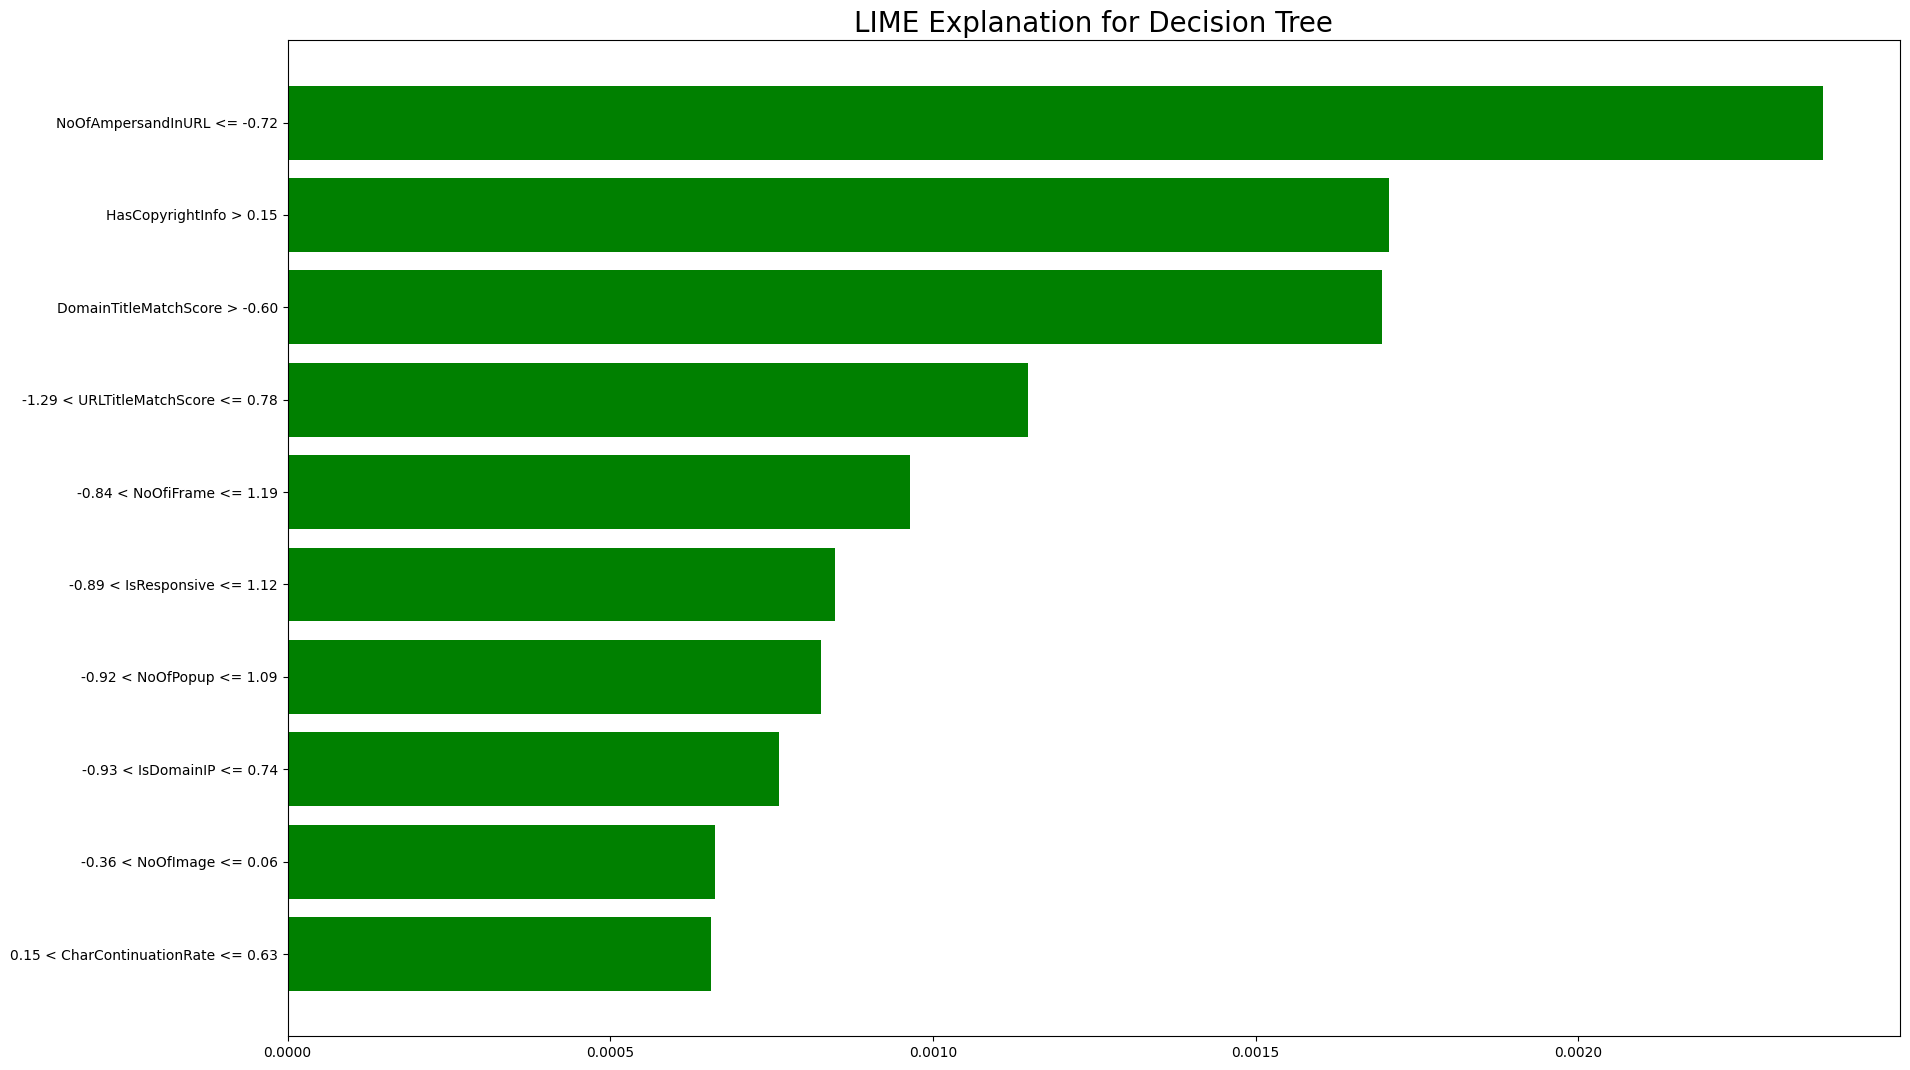


[INFO] Generating explanation for model: SVM
Intercept -0.15041868566550354
Prediction_local [0.638502]
Right: 0.9999998904394299


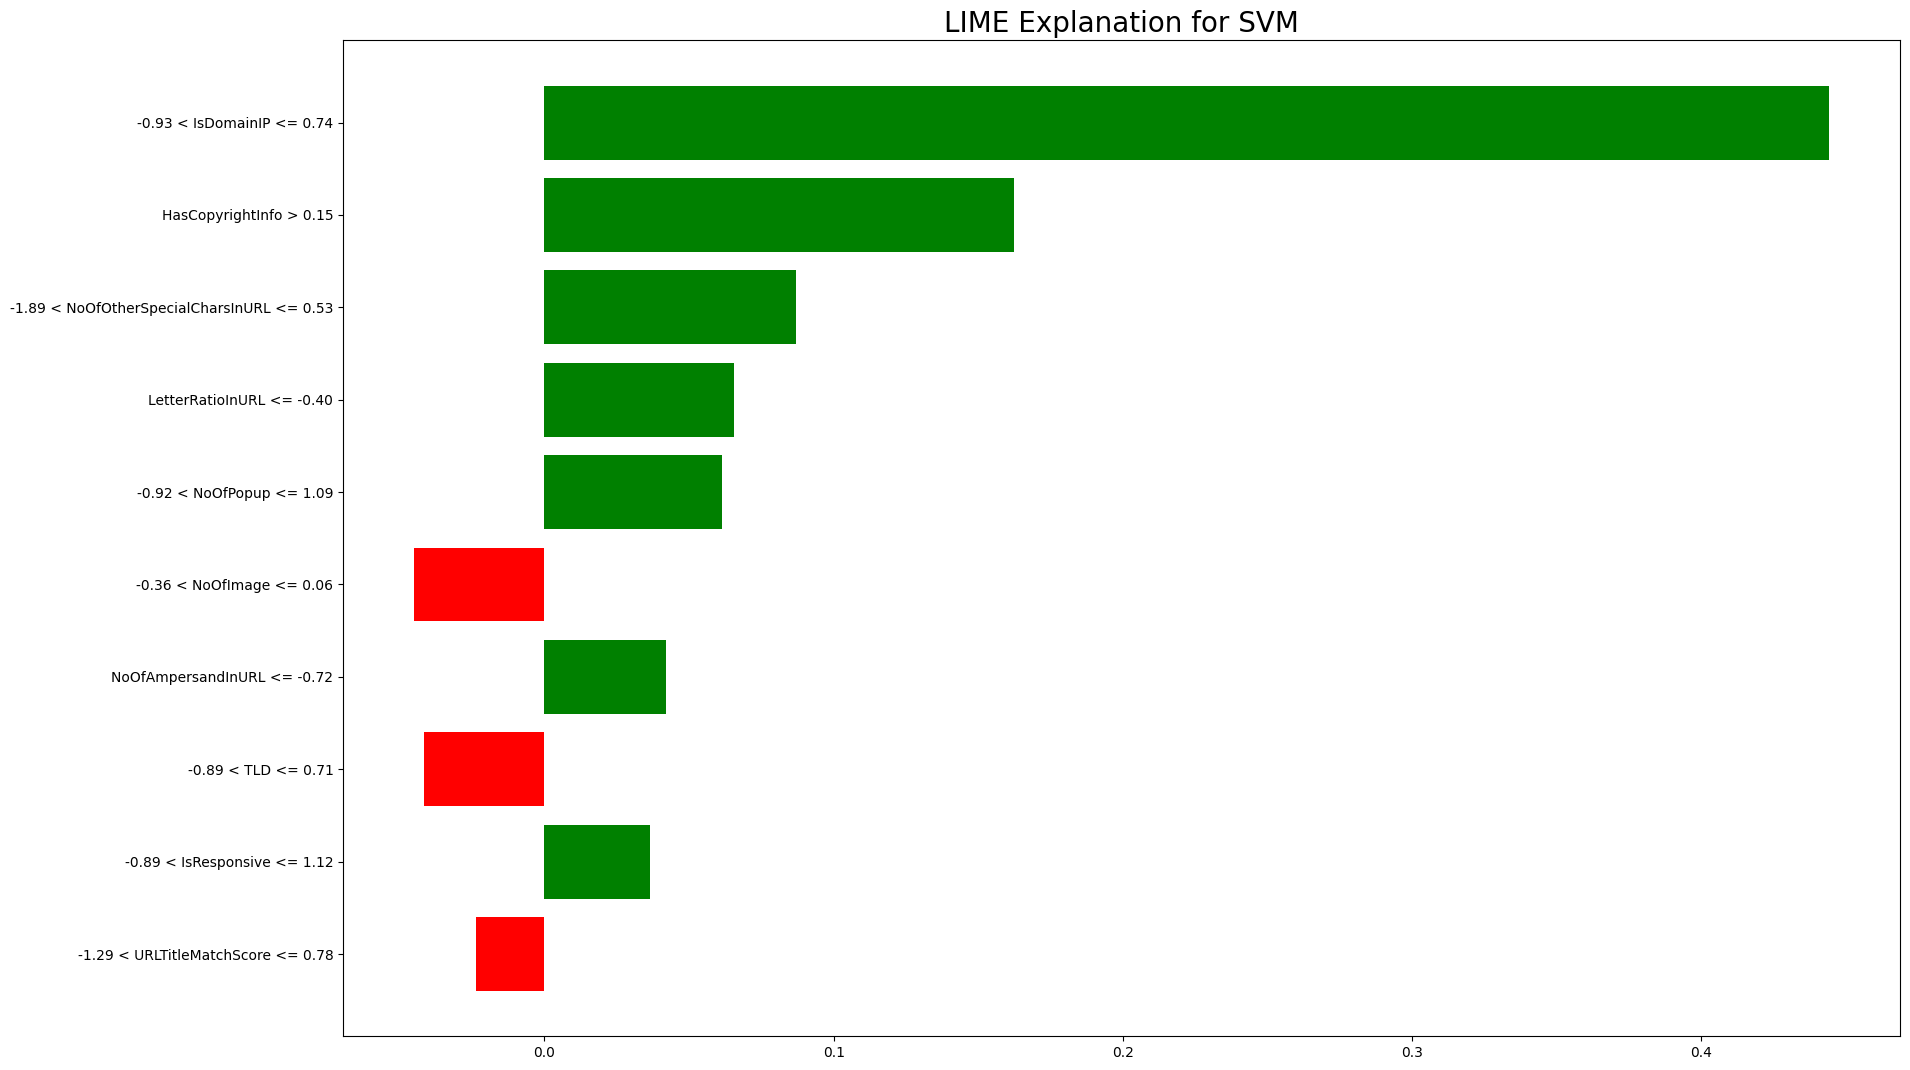


[INFO] Generating explanation for model: Logistic Regression
Intercept -0.13186680031435116
Prediction_local [0.96318911]
Right: 0.999999999941162


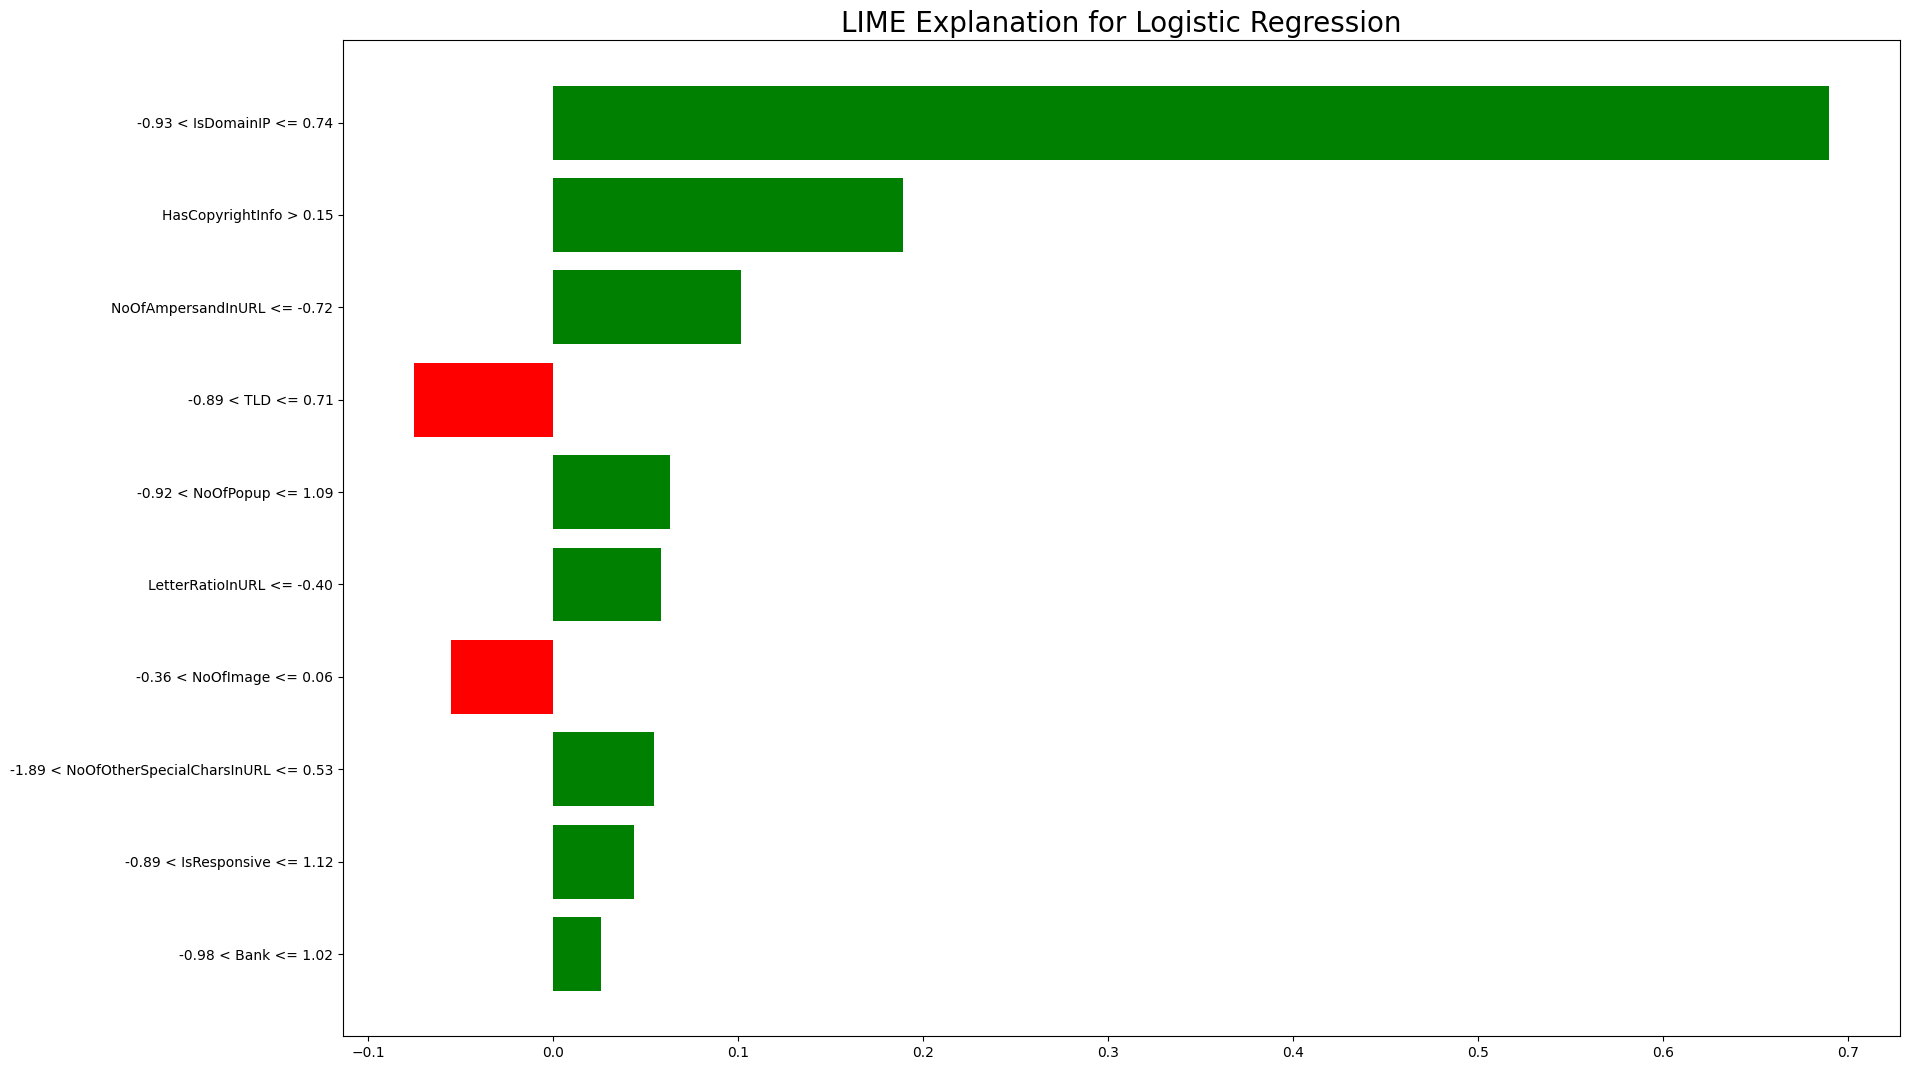


[INFO] Generating explanation for model: Random Forest
Intercept -0.0020062838564946506
Prediction_local [0.19839497]
Right: 1.0


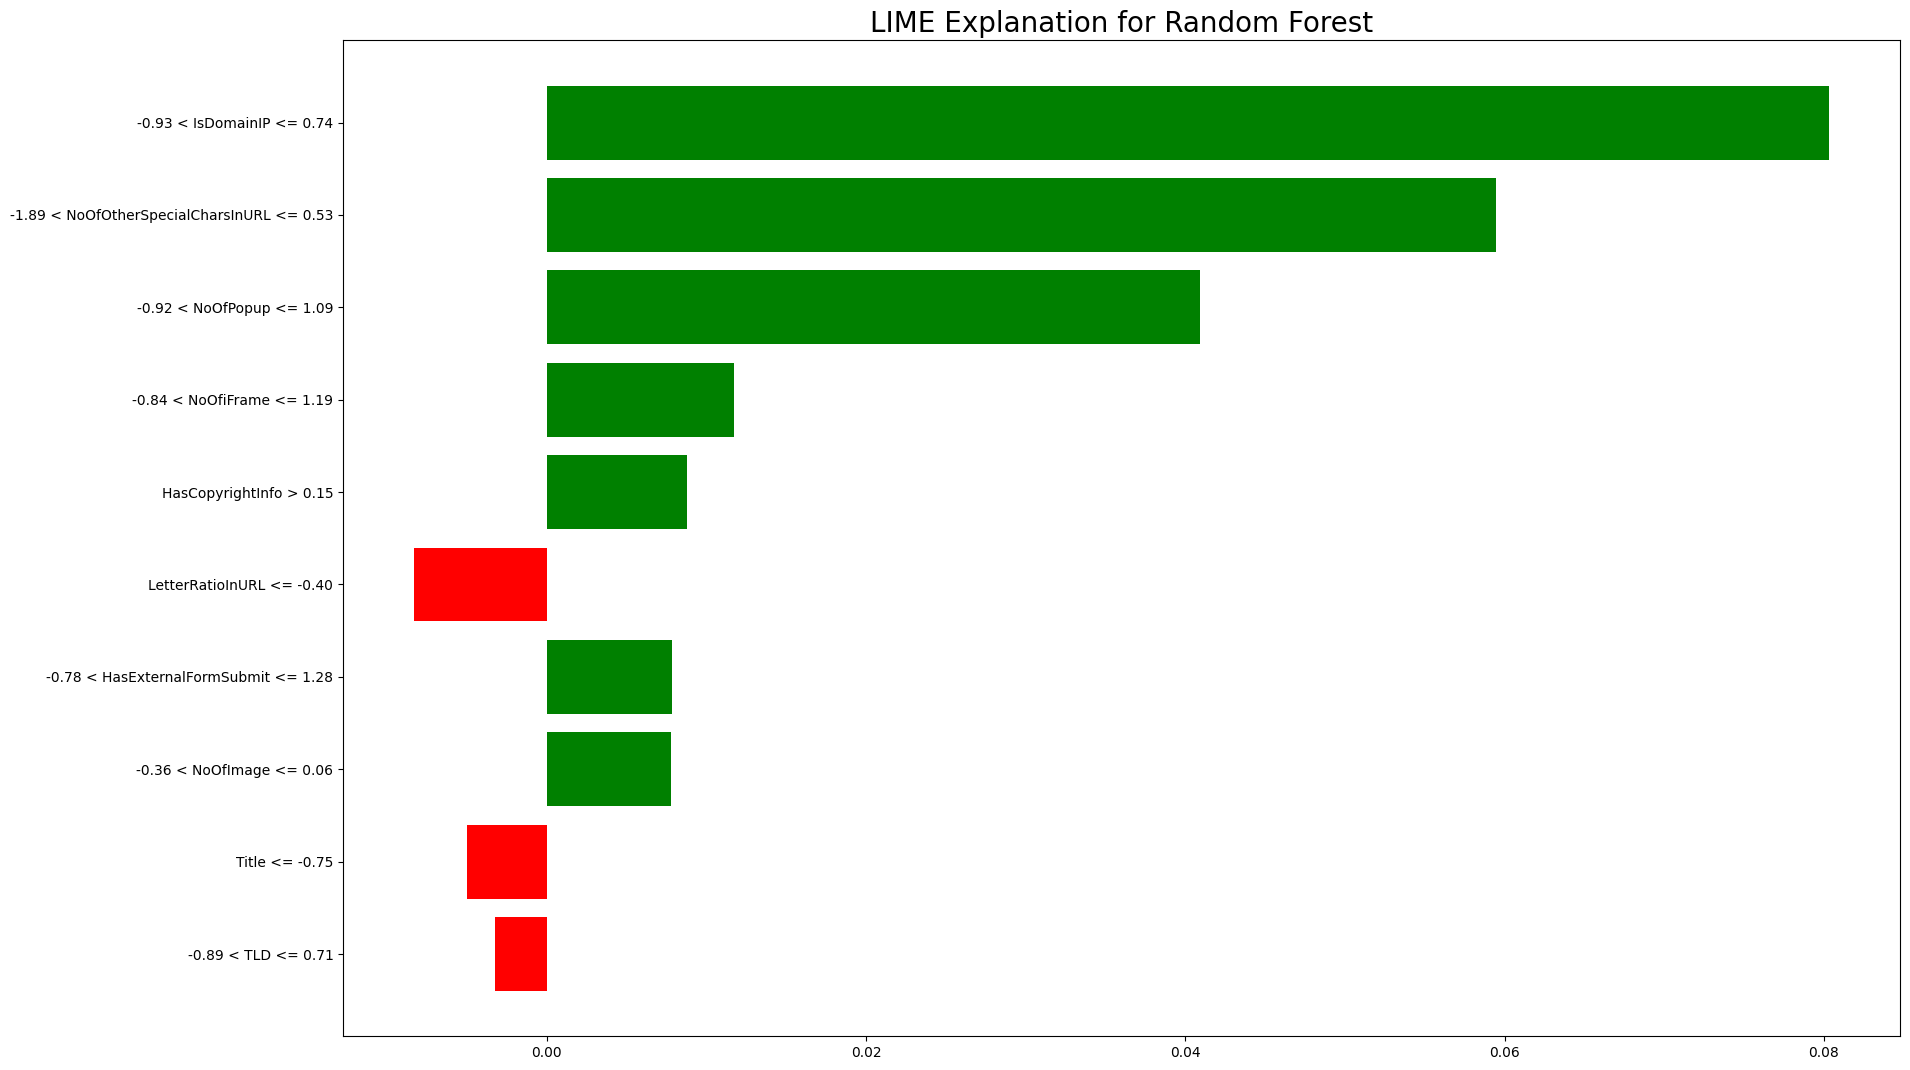


[INFO] Generating explanation for model: Gradient Boosting
Intercept -0.007317940784982911
Prediction_local [0.00929412]
Right: 0.9999724820708972


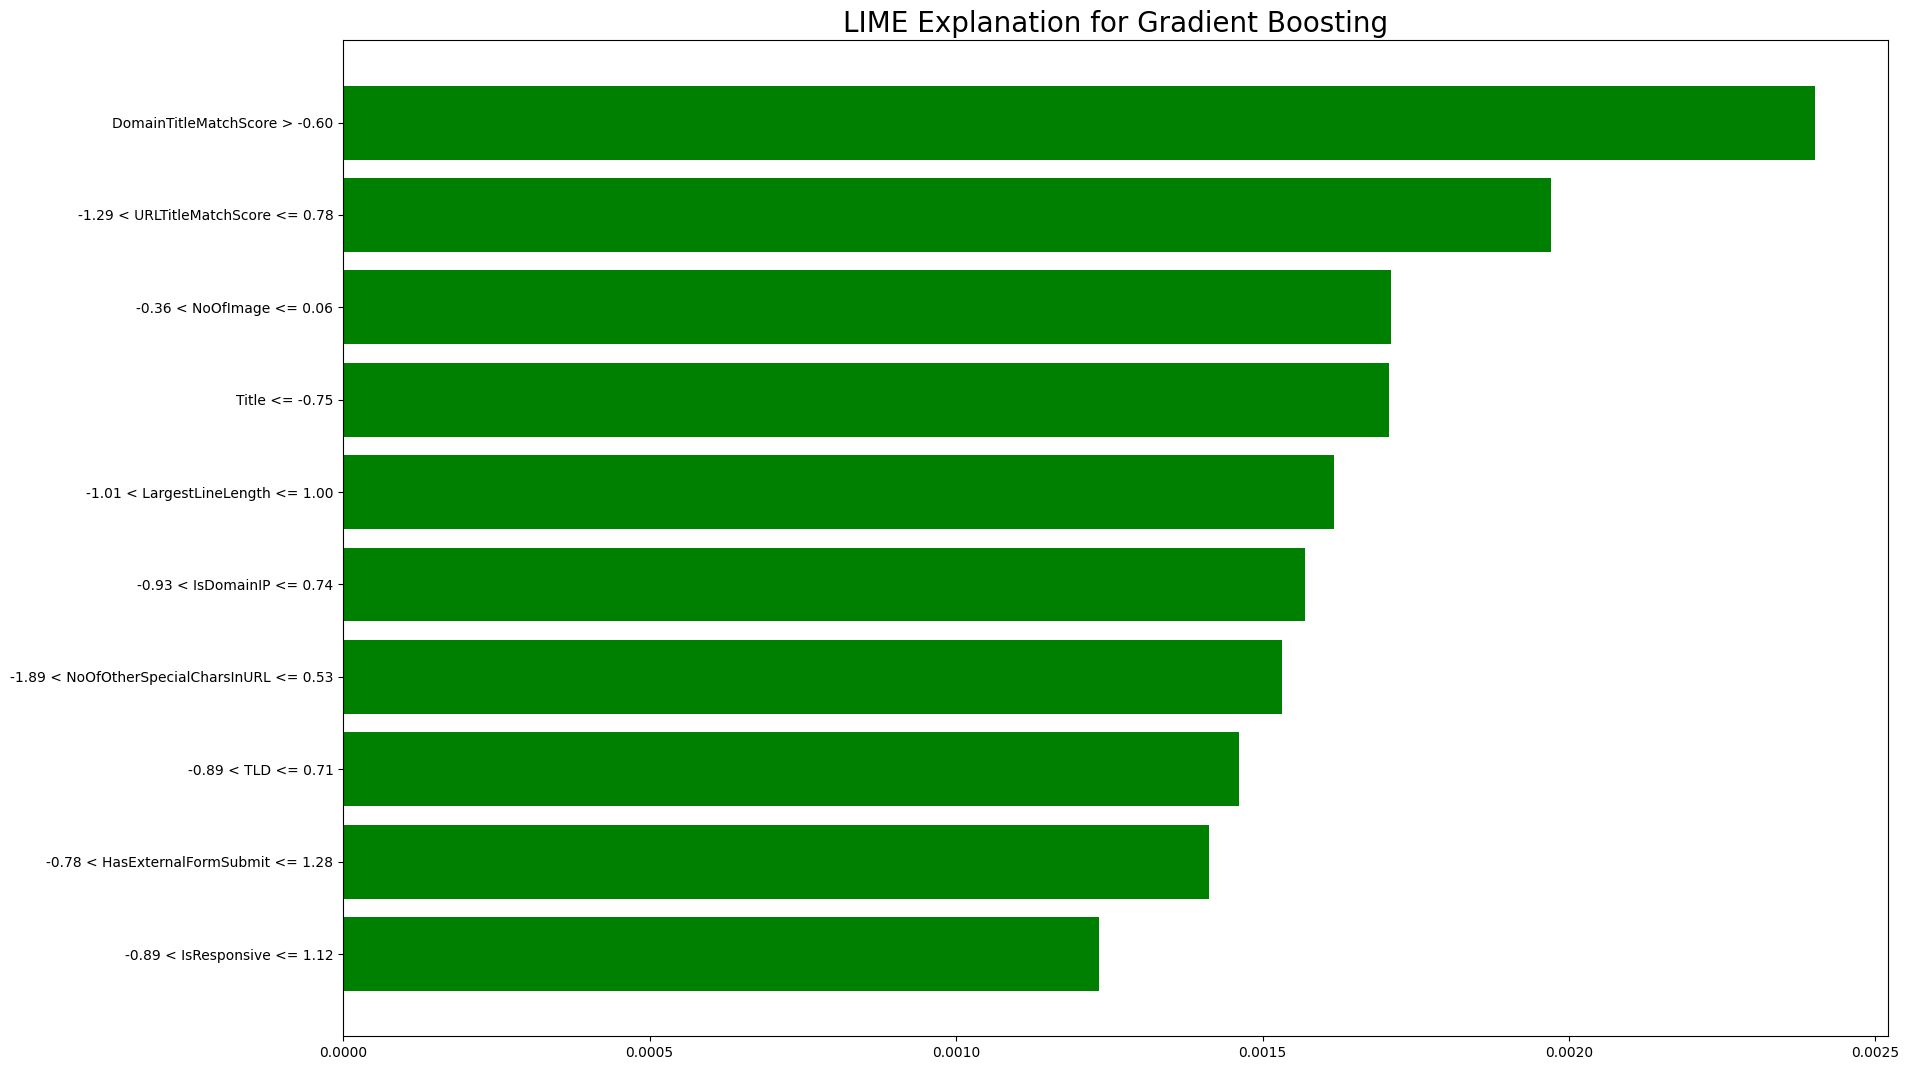


[INFO] Generating explanation for model: Stacking
Intercept -0.03907754748892267
Prediction_local [0.1077435]
Right: 0.9996993799423081


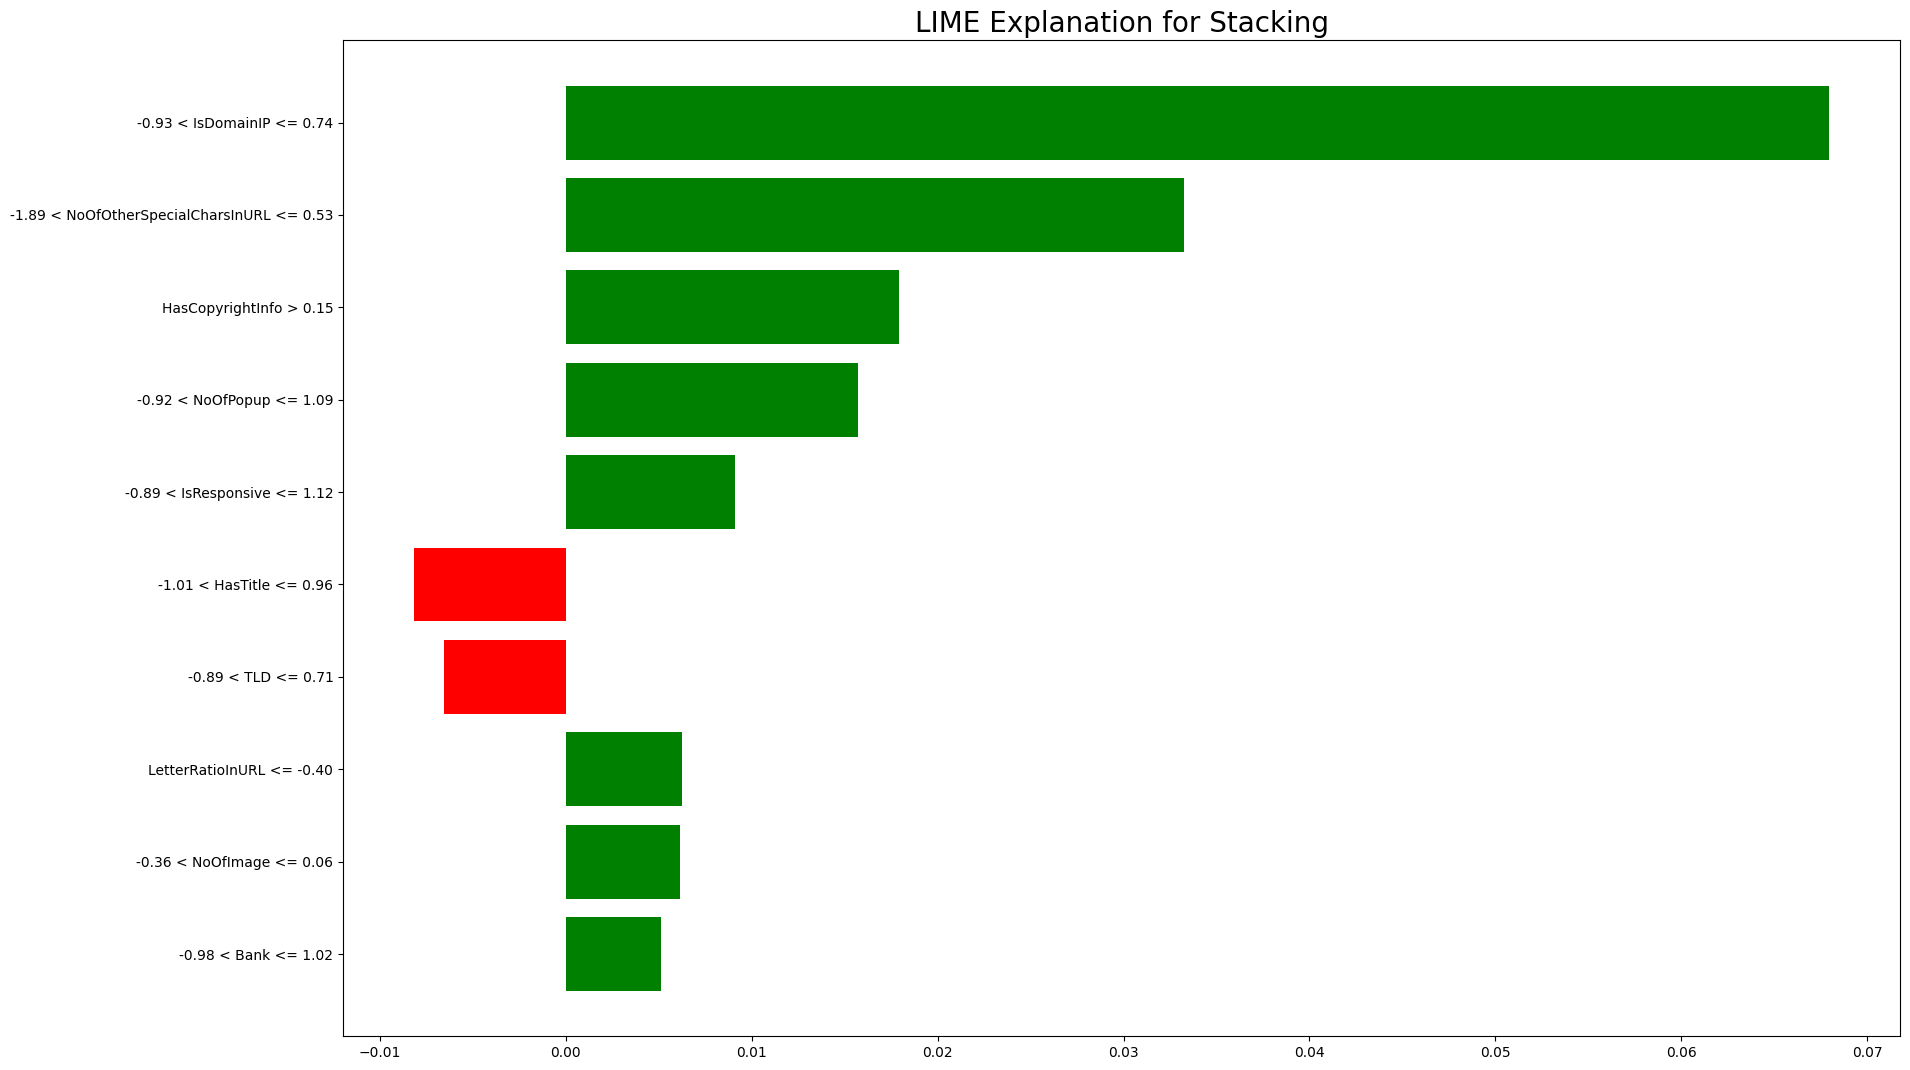


[INFO] Generating explanation for model: KNN
Intercept 0.09619654423407098
Prediction_local [1.38514685]
Right: 1.0


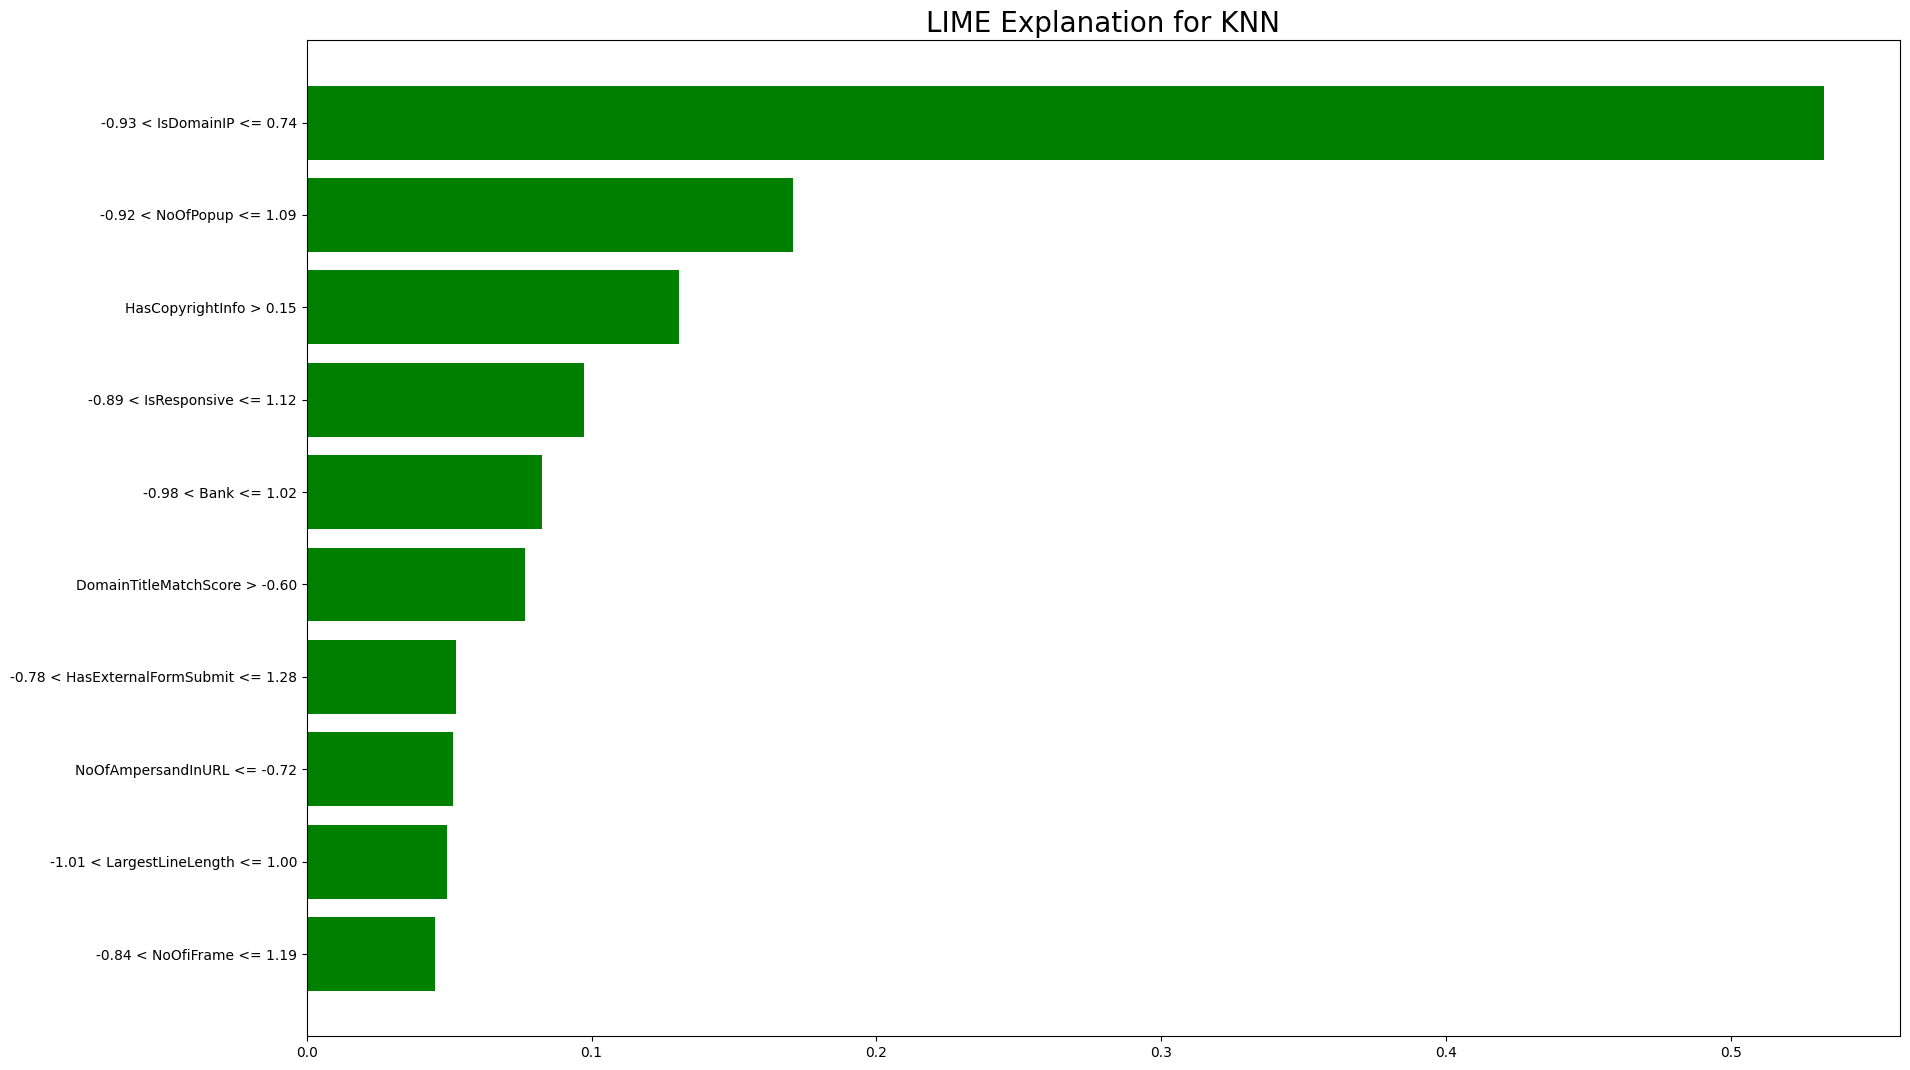


[INFO] Generating explanation for model: XGBoost
Intercept -0.0026901400266435946
Prediction_local [0.00697954]
Right: 0.9999697


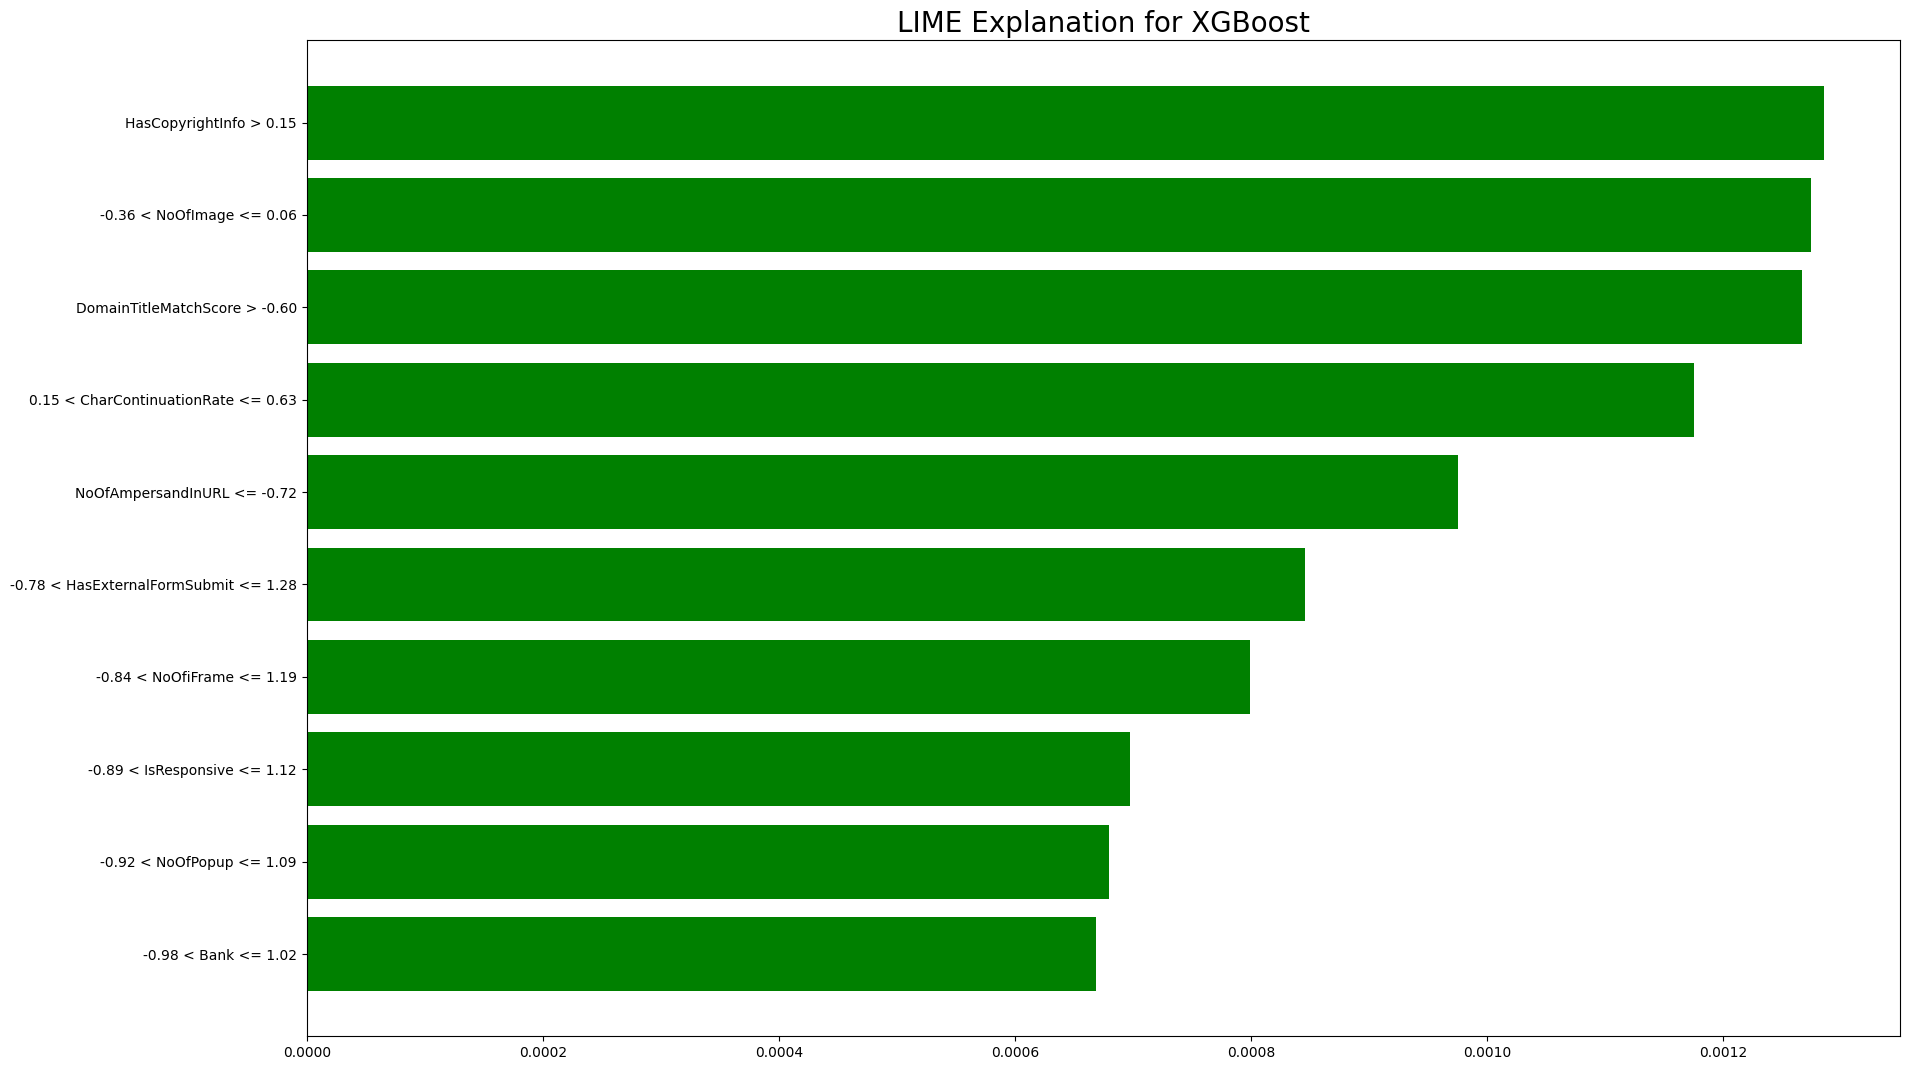

In [41]:
# Ensure the instance is 1D
i = 5
instance = X_test_fs[i]

# Create the explainer once
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_fs,
    feature_names=selected_feature_names,
    class_names=['Legitimate', 'Phishing'],
    mode='classification',
    verbose=True
)

# List of model names
model_names = [
    'Decision Tree',
    'SVM',
    'Logistic Regression',
    'Random Forest',
    'Gradient Boosting',
    'Stacking',
    'KNN',
    'XGBoost'
]

# Generate LIME explanations for all models
for model_name in model_names:
    model = models[model_name]

    # Check if model supports probability prediction
    if not hasattr(model, "predict_proba"):
        print(f"[SKIP] Model '{model_name}' does not support predict_proba.")
        continue

    print(f"\n[INFO] Generating explanation for model: {model_name}")

    # Explain the instance
    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=model.predict_proba
    )

    # Plot with 1080p resolution
    fig = exp.as_pyplot_figure()
    fig.set_size_inches(19.2, 10.8)
    plt.title(f"LIME Explanation for {model_name}", fontsize=20)
    plt.tight_layout()
    plt.show()
